# Costumer Churn Prediction with XGBoost

## Import Library

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from warnings import filterwarnings
filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.utils import save_model, load_model
from jcopml.plot import plot_missing_value
from jcopml.feature_importance import mean_score_decrease, mean_loss_decrease

## Load Data

In [2]:
df = pd.read_csv("data/train_new.csv")
df.head()

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
0,OH,107,area_code_415,no,yes,26,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0
1,NJ,137,area_code_415,no,no,0,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0
2,OH,84,area_code_408,yes,no,0,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,0
3,OK,75,area_code_415,yes,no,0,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,0
4,MA,121,area_code_510,no,yes,24,88,37.09,348.5,108,29.62,212.6,118,9.57,7.5,7,2.03,3,0


In [3]:
df.shape

(4250, 19)

In [4]:
df.dtypes

state                             object
account_length                     int64
area_code                         object
international_plan                object
voice_mail_plan                   object
number_vmail_messages              int64
total_day_calls                    int64
total_day_charge                 float64
total_eve_minutes                float64
total_eve_calls                    int64
total_eve_charge                 float64
total_night_minutes              float64
total_night_calls                  int64
total_night_charge               float64
total_intl_minutes               float64
total_intl_calls                   int64
total_intl_charge                float64
number_customer_service_calls      int64
churn                              int64
dtype: object

In [5]:
df.describe()

,account_length,number_vmail_messages,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
count,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000
mean,100.236235,7.631765,99.907294,30.644682,200.173906,100.176471,17.015012,200.527882,99.839529,9.023892,10.256071,4.426353,2.769654,1.559059,0.140706
std,39.698401,13.439882,19.850817,9.182096,50.249518,19.908591,4.271212,50.353548,20.093220,2.265922,2.760102,2.463069,0.745204,1.311434,0.347759
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,73.000000,0.000000,87.000000,24.365000,165.925000,87.000000,14.102500,167.225000,86.000000,7.522500,8.500000,3.000000,2.300000,1.000000,0.000000
50%,100.000000,0.000000,100.000000,30.680000,200.700000,100.000000,17.060000,200.450000,100.000000,9.020000,10.300000,4.000000,2.780000,1.000000,0.000000
75%,127.000000,16.000000,113.000000,36.750000,233.775000,114.000000,19.867500,234.700000,113.000000,10.560000,12.000000,6.000000,3.240000,2.000000,0.000000
max,243.000000,52.000000,165.000000,59.760000,359.300000,170.000000,30.540000,395.000000,175.000000,17.770000,20.000000,20.000000,5.400000,9.000000,1.000000


In [6]:
df.describe(include='O')

,state,area_code,international_plan,voice_mail_plan
count,4250,4250,4250,4250
unique,51,3,2,2
top,WV,area_code_415,no,no
freq,139,2108,3854,3138


## Dataset Splitting

In [7]:
X = df.drop(columns="churn")
y = df.churn

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3400, 18), (850, 18), (3400,), (850,))

## Modeling

In [8]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from jcopml.tuning import random_search_params as rsp
from jcopml.tuning.space import Integer, Real
import category_encoders as ce
from sklearn.impute import SimpleImputer

In [9]:
# filter fitur numerik dan categoric 
numeric = list(X_train.dtypes[X_train.dtypes != 'object'].index)
categoric = list(X_train.dtypes[X_train.dtypes == 'object'].index)

In [10]:
cat_pipe2 = Pipeline([
('imputer', SimpleImputer(strategy='most_frequent')),
('onehot', ce.BinaryEncoder())
])

In [11]:
X_train.head()

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls
3835,NE,166,area_code_415,no,no,0,117,40.56,242.8,73,20.64,203.3,130,9.15,10.0,8,2.70,4
1518,CT,125,area_code_415,yes,no,0,118,31.84,160.7,111,13.66,263.8,112,11.87,9.6,2,2.59,0
1704,NC,89,area_code_408,no,no,0,151,18.00,189.6,142,16.12,170.9,67,7.69,12.7,7,3.43,0
3808,VT,83,area_code_510,no,yes,37,117,22.63,171.4,89,14.57,218.1,92,9.81,10.9,4,2.94,3
1448,AZ,100,area_code_415,no,no,0,152,32.05,148.3,115,12.61,179.8,88,8.09,15.2,5,4.10,2


In [12]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(), numeric),
    ('categoric', cat_pipe(encoder='onehot'), ['area_code', 'international_plan', 'voice_mail_plan']),
    ('categoric2', cat_pipe2, ['state']),
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', XGBClassifier(n_jobs=-2, random_state=42, verbosity=0))
])

model = RandomizedSearchCV(pipeline, rsp.xgb_params, cv=5, scoring='f1', n_iter=50, n_jobs=-2, verbose=1, random_state=42)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-2)]: Done  44 tasks      | elapsed:   34.7s
[Parallel(n_jobs=-2)]: Done 194 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-2)]: Done 250 out of 250 | elapsed:  2.6min finished


{'algo__colsample_bytree': 0.9763799669573133, 'algo__gamma': 3, 'algo__learning_rate': 0.05820013372709852, 'algo__max_depth': 4, 'algo__n_estimators': 163, 'algo__reg_alpha': 0.07362945281639222, 'algo__reg_lambda': 2.752717392942944, 'algo__subsample': 0.6401537692938899}
0.8967082860385927 0.8240743415667581 0.8252427184466019


## Features Important

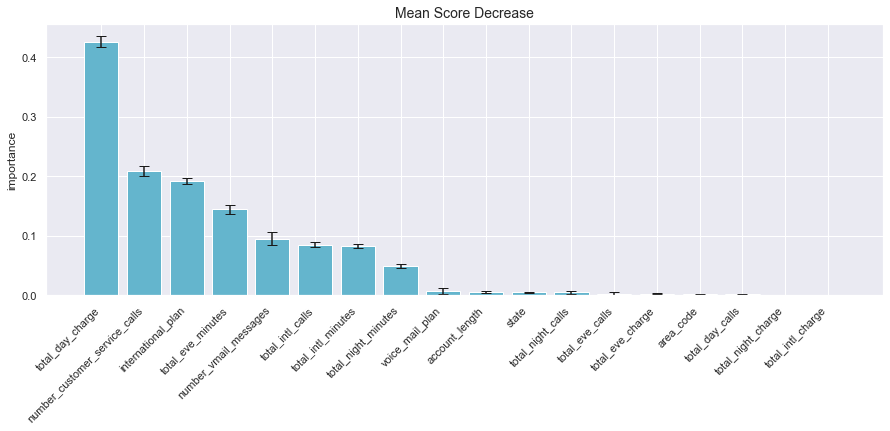

In [13]:
df_imp = mean_score_decrease(X_train, y_train, model, plot=True)

total_day_charge merupakan fitur paling penting dalam memprediksi apakah seseorang akan churn atau tidak.

In [14]:
feat_imp = list(df_imp.feature[:8])

In [15]:
numeric2 = list(X_train[feat_imp].dtypes[X_train[feat_imp].dtypes != 'object'].index)

In [16]:
categoric2 = list(X_train[feat_imp].dtypes[X_train[feat_imp].dtypes == 'object'].index)

In [17]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(), numeric2),
    ('categoric', cat_pipe(encoder='onehot'), categoric2),
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', XGBClassifier(n_jobs=-2, random_state=42, verbosity=0))
])

model = RandomizedSearchCV(pipeline, rsp.xgb_params, cv=5, scoring='f1', n_iter=50, n_jobs=-2, verbose=1, random_state=42)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-2)]: Done  44 tasks      | elapsed:   18.0s
[Parallel(n_jobs=-2)]: Done 194 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-2)]: Done 250 out of 250 | elapsed:  1.6min finished


{'algo__colsample_bytree': 0.9763799669573133, 'algo__gamma': 3, 'algo__learning_rate': 0.05820013372709852, 'algo__max_depth': 4, 'algo__n_estimators': 163, 'algo__reg_alpha': 0.07362945281639222, 'algo__reg_lambda': 2.752717392942944, 'algo__subsample': 0.6401537692938899}
0.8931818181818182 0.83484301391972 0.8365384615384616


Setelah dilakukan feature selection after modeling terjadi kenaikan skor pada test >1%.

## Polynomial Features 

In [18]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(poly=2), numeric2),
    ('categoric', cat_pipe(encoder='onehot'), categoric2),
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', XGBClassifier(n_jobs=-2, random_state=42, verbosity=0))
])

model = RandomizedSearchCV(pipeline, rsp.xgb_poly_params, cv=5, scoring='f1', n_iter=50, n_jobs=-2, verbose=1, random_state=42)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-2)]: Done  44 tasks      | elapsed:   40.1s
[Parallel(n_jobs=-2)]: Done 194 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-2)]: Done 250 out of 250 | elapsed:  3.5min finished


{'algo__colsample_bytree': 0.3516043076170827, 'algo__gamma': 6, 'algo__learning_rate': 0.054994264803456094, 'algo__max_depth': 9, 'algo__n_estimators': 136, 'algo__reg_alpha': 5.1674258133224225, 'algo__reg_lambda': 0.051610324923470736, 'algo__subsample': 0.7833274095218349, 'prep__numeric__poly__degree': 3, 'prep__numeric__poly__interaction_only': False}
0.8962371721778791 0.8695213308889521 0.8530805687203792


## Fine Tuning

In [19]:
drop = list(df_imp.feature[8:])

In [20]:
X_train.drop(columns=drop, axis=1, inplace=True)
X_test.drop(columns=drop, axis=1, inplace=True)

In [21]:
X_train.shape, X_test.shape

((3400, 8), (850, 8))

In [22]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(poly=2), numeric2),
    ('categoric', cat_pipe(encoder='onehot'), categoric2),
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', XGBClassifier(n_jobs=-2, random_state=42, verbosity=0))
])

parameter = {'prep__numeric__poly__degree': Integer(low=1, high=3),
             'prep__numeric__poly__interaction_only': [True, False],
             'algo__max_depth': Integer(low=1, high=9),
             'algo__learning_rate': Real(low=-2, high=0, prior='log-uniform'),
             'algo__n_estimators': Integer(low=100, high=198),
             'algo__subsample': Real(low=0.3, high=0.77, prior='uniform'),
             'algo__gamma': Integer(low=1, high=3),
             'algo__colsample_bytree': Real(low=0.1, high=0.36, prior='uniform'),
             'algo__reg_alpha': Real(low=-1, high=3, prior='log-uniform'),
             'algo__reg_lambda': Real(low=-1, high=2, prior='log-uniform')}

model = RandomizedSearchCV(pipeline, parameter, cv=5, scoring='f1', n_iter=50, n_jobs=-2, verbose=1, random_state=42)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-2)]: Done  44 tasks      | elapsed:   21.6s
[Parallel(n_jobs=-2)]: Done 194 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-2)]: Done 250 out of 250 | elapsed:  2.0min finished


{'algo__colsample_bytree': 0.32178245842151365, 'algo__gamma': 3, 'algo__learning_rate': 0.040869002562844765, 'algo__max_depth': 7, 'algo__n_estimators': 132, 'algo__reg_alpha': 1.8522006003174383, 'algo__reg_lambda': 0.32246177486423727, 'algo__subsample': 0.5616965933554245, 'prep__numeric__poly__degree': 3, 'prep__numeric__poly__interaction_only': False}
0.9164785553047404 0.8740564224534124 0.8785046728971964


Model telah mendapatkan hyperparameter optimal. Jika dibandingkan dengan baseline, terjadi sedikit kenaikan skor pada test. 

## Evaluation

In [23]:
from jcopml.plot import plot_classification_report, plot_confusion_matrix, plot_pr_curve, plot_roc_curve

In [24]:
plot_classification_report(X_train, y_train, X_test, y_test, model, report=True)

Train report
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      2922
           1       1.00      0.85      0.92       478

    accuracy                           0.98      3400
   macro avg       0.99      0.92      0.95      3400
weighted avg       0.98      0.98      0.98      3400


Test report
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       730
           1       1.00      0.78      0.88       120

    accuracy                           0.97       850
   macro avg       0.98      0.89      0.93       850
weighted avg       0.97      0.97      0.97       850



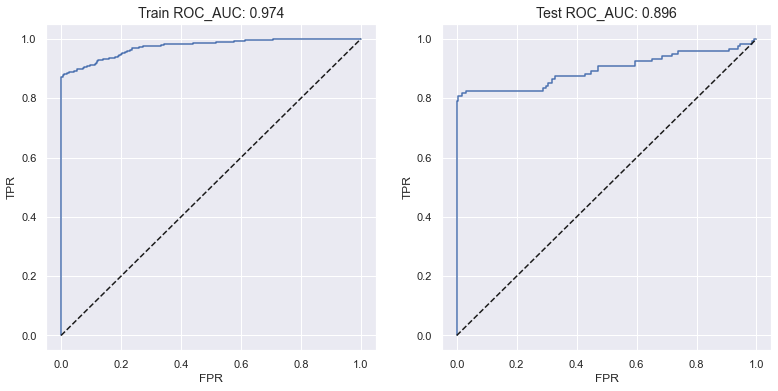

In [25]:
plot_roc_curve(X_train, y_train, X_test, y_test, model)

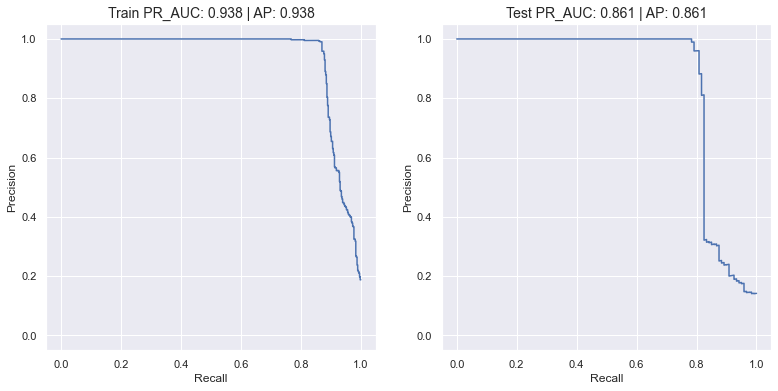

In [26]:
plot_pr_curve(X_train, y_train, X_test, y_test, model)

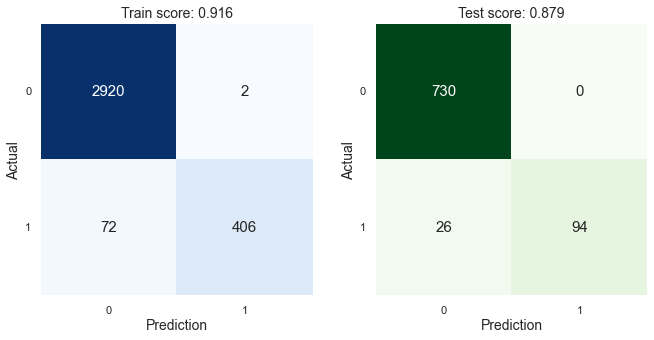

In [27]:
plot_confusion_matrix(X_train, y_train, X_test, y_test, model)

## Save Model

In [28]:
save_model(model.best_estimator_, "churn_xgb.pkl")

Model is pickled as model/churn_xgb.pkl
